In [2]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

In [ ]:
!pip install recommenders

In [4]:

from recommenders.models.rbm.rbm import RBM
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.sparse import AffinityMatrix
from recommenders.datasets import movielens
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.utils.plot import line_graph

### Food.com   Dataset
- https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions
- https://aclanthology.org/D19-1613/

In [5]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!gdown https://drive.google.com/uc?id=1dK__rulbUEGU_m68RIK7Qevc7pcpOIme
!gdown https://drive.google.com/uc?id=1dN-wpxE3V8yNVKPByHReEaswl9UNV9wj

Downloading...
From: https://drive.google.com/uc?id=1dK__rulbUEGU_m68RIK7Qevc7pcpOIme
To: /content/RAW_recipes.csv
100% 295M/295M [00:01<00:00, 177MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dN-wpxE3V8yNVKPByHReEaswl9UNV9wj
To: /content/RAW_interactions.csv
100% 349M/349M [00:02<00:00, 137MB/s]


In [7]:
raw_interactions_df = pd.read_csv('RAW_interactions.csv')
raw_interactions_df['review']= raw_interactions_df['review'].astype(str)
raw_interactions_df.head(5)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [8]:
raw_recipes_df = pd.read_csv('RAW_recipes.csv')

raw_recipes_df.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [9]:
raw_interactions_df.info()
rating_df=raw_interactions_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132367 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


### Prepare dataset

In [10]:
rating_df=rating_df[['user_id','recipe_id','date','rating']]
rating_df.rename(columns = {'user_id':'userID', 'recipe_id':'itemID'}, inplace = True)

x = rating_df.groupby('itemID').count()['rating'] >= 40
userIndex = x[x].index
nm_rating_df=rating_df[rating_df['itemID'].isin(userIndex)]
y = nm_rating_df.groupby('userID').count()['rating']>=60
items = y[y].index
rating_df = nm_rating_df[nm_rating_df['userID'].isin(items)]
rating_df.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(50686, 4)

In [11]:
unique_users = rating_df.userID.unique()
user_ids = dict(zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))

unique_items = rating_df.itemID.unique()
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

In [12]:
product_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

### Train and test dataset

In [13]:
test_df=rating_df.groupby('userID').head(20)
test_df.shape

(9340, 4)

In [14]:
train_df=rating_df[~rating_df.isin(test_df).all(1)]
train_df.shape

(41346, 4)

##### Install packages

### Look at distribution of ratings

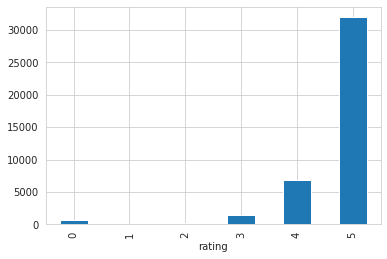

In [15]:
train_df.groupby(['rating']).size().plot(kind = "bar")

### user/item affiity matrix 

In [16]:
header = {
        "col_user": "userID",
        "col_item": "itemID",
        "col_rating": "rating",
    }

#instantiate the sparse matrix generation  
am = AffinityMatrix(df = train_df, **header)

#obtain the sparse matrix 
X, _, _ = am.gen_affinity_matrix()

In [17]:
#Xtrn, Xtst = numpy_stratified_split(X)

### RBM

In [18]:
#First we initialize the model class
model = RBM(
    possible_ratings=np.setdiff1d(np.unique(X), np.array([0])),
    visible_units=X.shape[1],
    hidden_units=600,
    training_epoch=30,
    minibatch_size=60,
    keep_prob=0.9,
    with_metrics=True
)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


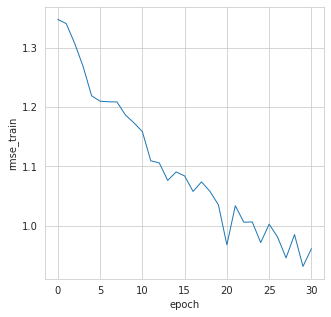

In [19]:
# Model Fit
model.fit(X)

# Plot the train RMSE as a function of the epochs
line_graph(values=model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')

TOP 10 recommendations

In [20]:
top_k =  model.recommend_k_items(X,10)


In [21]:
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')



In [22]:
usersinTestDataset=list(test_df.userID.unique())

In [23]:
top_k_df=top_k_df[top_k_df.userID.isin(usersinTestDataset)]

### Evaluation metrics

HIT Rate

In [32]:
total=0
hit=0
for i in usersinTestDataset:
    results= list(top_k_df[top_k_df['userID']==i].itemID )   
  
    total+=1
    for rs in results:
        
        if(((test_df['itemID'] == rs) & (test_df['userID'] ==i)).any()):
                hit+=1
                break
        
hit_ratio=hit/total   
print(hit_ratio)

0.06423982869379015


MAP@K

In [33]:
total=0
hit=0
for i in usersinTestDataset:
    results= list(top_k_df[top_k_df['userID']==i].itemID )   
  
   
    for rs in results:
        total+=1
        if(((test_df['itemID'] == rs) & (test_df['userID'] ==i)).any()):
                hit+=1
               
        
hit_ratio=hit/total   
print(hit_ratio)

0.006638115631691649
